# 10 quad optimization

Consider a beamline with 10 quarupoles separated by drifts. The initial beam profile in $x$-$y$ is elliptical and we want a round beam downstream with beamsize $\sigma_{\mathrm{target}} = 5.00~\mathrm{mm}$. Let's find the 10 quadrupole strengths such that this happens by using gradient based optimization and automatic differentiation.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from bmadx import Particle, Drift, Quadrupole
from bmadx import track_element, track_lattice
from bmadx import M_ELECTRON
%config InlineBackend.figure_format = 'retina'

In [2]:
# Create particle beam

n_particles = 10_000
p0c = 4e7 # reference momentum in eV
mean = torch.zeros(6)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 3e-6, 2e-6, 1e-6, 2e-6]))
torch.manual_seed(0)
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
coords = dist.sample(torch.Size([n_particles])) # particles' coordinates

beam_in = Particle(*coords.T,
                   s=torch.tensor(0.),
                   p0c=torch.tensor(p0c),
                   mc2=M_ELECTRON)

Text(0, 0.5, '$y$ (mm)')

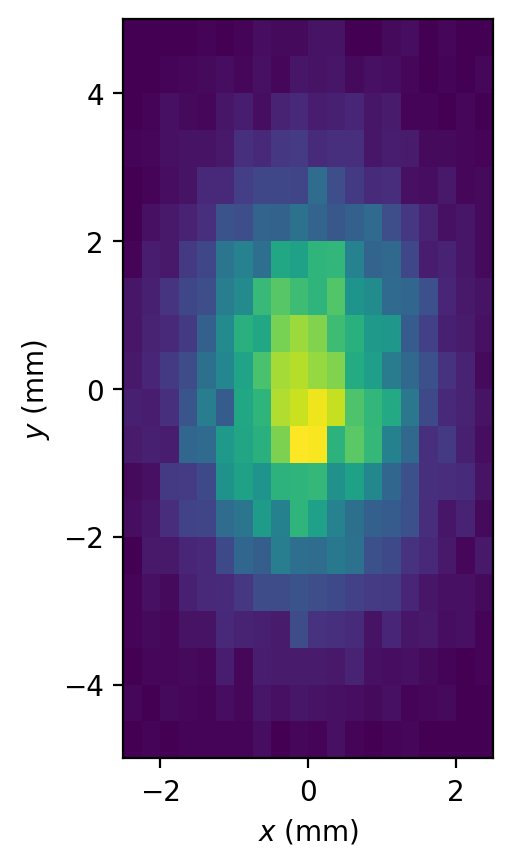

In [3]:
# plot initial beam distribution
fig, ax = plt.subplots()
ax.hist2d(beam_in.x.numpy()*1e3, 
          beam_in.y.numpy()*1e3, 
          bins=20, 
          range=[[-2.5,2.5],[-5,5]])
ax.set_aspect('equal')
ax.set_xlabel(r'$x$ (mm)')
ax.set_ylabel(r'$y$ (mm)')

In [4]:
sigma_target = 5e-3 # target beam size

We can define the loss function as the pythagorean sum of the beamsize discrepancies in $x$ and $y$: $$L = \sqrt{\Delta_x^2+\Delta_y^2}~,$$ where $\Delta_i = \sigma_i-\sigma_{\mathrm{target}}$.

Now let's create a model of the beamline and find the set of quarupole strengths $\{k_1, ..., k_{10}\}$ that minimize $L$. 

In [5]:
ld = 0.9
lq = 0.1

half_drift = Drift(L=ld) # each drift is 90 cm long

In [6]:
# Model to optimize (we can inheritate from torch.nn.Module and use PyTorch optimizers)
class BeamlineModel(torch.nn.Module):
    """Beamline torch module."""
    def __init__(self, k_set):
        super().__init__()
        # register set of quad strengths as parameter:
        self.register_parameter('k_set',torch.nn.Parameter(k_set))
    def forward(self):
        lattice = []
        for k1 in self.k_set:
            lattice.append( half_drift )
            lattice.append( Quadrupole(L=lq, K1=k1) )
            lattice.append( half_drift )
            
        # outgoing particle:
        p_out = track_lattice(beam_in, lattice)
        
        # calculate and return loss function:
        sigma_x = torch.std(p_out.x)
        sigma_y = torch.std(p_out.y)
        dx = (sigma_x - sigma_target)
        dy = (sigma_y - sigma_target)
        return torch.sqrt(dx**2+dy**2)

In [7]:
# Training function
def train_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter # list to save params
    history_loss = [None] * training_iter # list to save loss
    
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use PyTorch Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward() # gradient
        
        # print info:
        if i%100==0: #print each 100 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss
            ))
        
        # save loss and param
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        
        # optimization step
        optimizer.step()
    
    # returns params and loss for every iteration
    return np.asarray(history_param), np.asarray(history_loss)

In [8]:
%%time
# Initial k_set
k_set = torch.zeros(10)

# Optimization
model = BeamlineModel(k_set)
params, loss = train_model(model, 500, 0.01)

k_set : Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Iter 1/500 - Loss: 0.03107 
Iter 101/500 - Loss: 0.00452 
Iter 201/500 - Loss: 0.00052 
Iter 301/500 - Loss: 0.00008 
Iter 401/500 - Loss: 0.00022 
CPU times: user 8.97 s, sys: 2.9 s, total: 11.9 s
Wall time: 11.1 s


Text(0, 0.5, 'loss $\\sqrt{\\Delta_x^2 + \\Delta_y^2}$ (mm)')

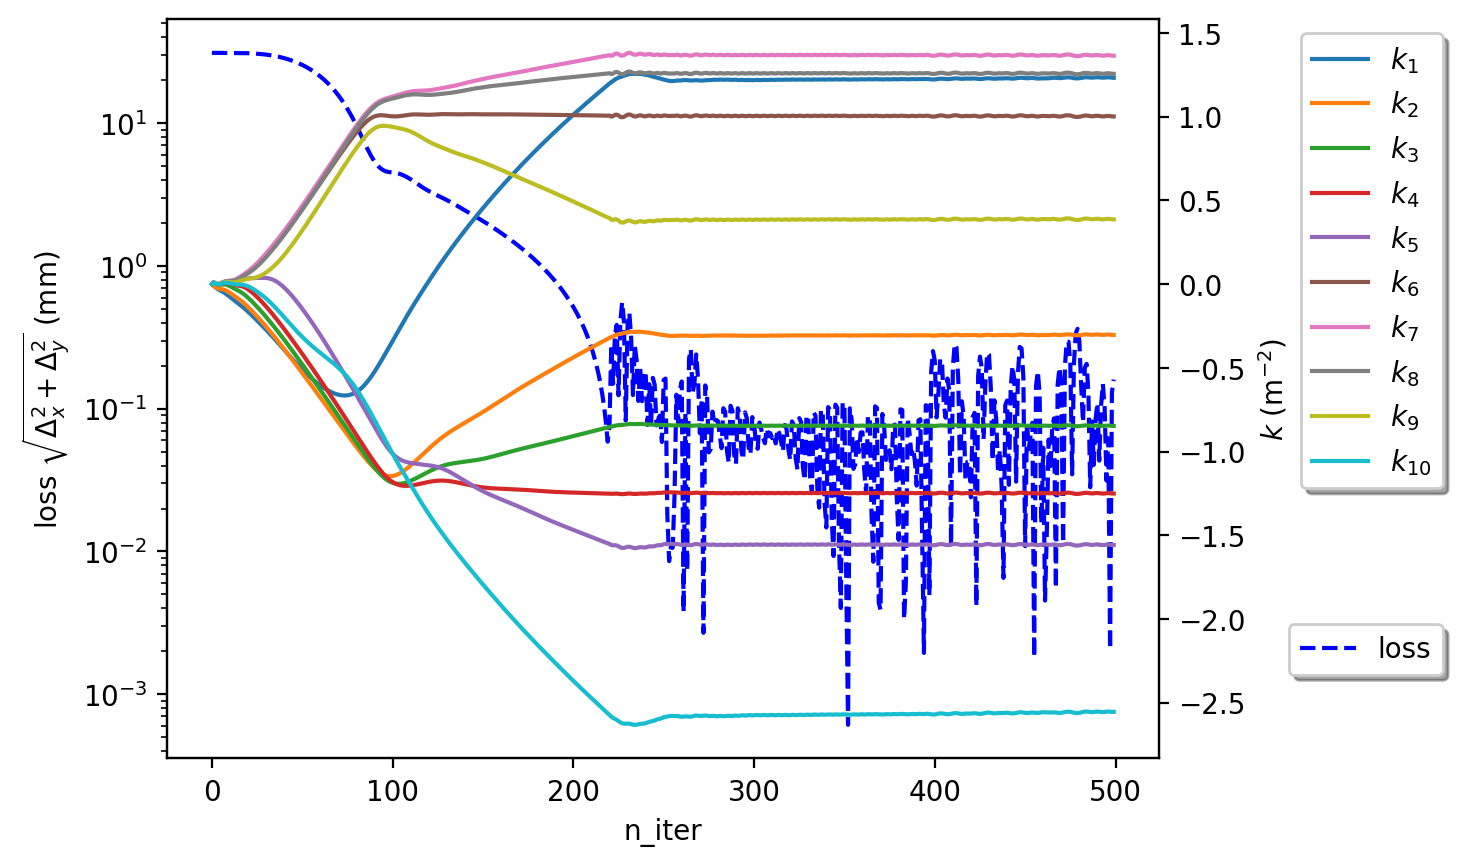

In [9]:
# Plot loss and parameters as function of iteration number
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(k_set)):
    ax2.plot(np.arange(len(params[:,0])), params[:,i], label=f'$k_{{{i+1}}}$')
ax1.plot(np.arange(len(loss)), loss*1000, '--b', label='loss')
ax1.set_yscale('log')                
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1, fancybox=True, shadow=True)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 0.2), ncol=1, fancybox=True, shadow=True)
ax1.set_xlabel('n_iter')
ax2.set_ylabel(r'$k$ (m$ ^{-2}$)')
ax1.set_ylabel(r'loss $\sqrt{\Delta_x^2 + \Delta_y^2}$ (mm)')

In [10]:
# save optimal set of quad strengths
k_opt = params[-1]
k_opt

array([ 1.2325145 , -0.3037093 , -0.8472598 , -1.2508814 , -1.5585349 ,
        1.0015095 ,  1.3644875 ,  1.256382  ,  0.38677675, -2.5550878 ],
      dtype=float32)

In [11]:
# create lattice with optimal quad strengths
lattice = []
for k1 in k_opt:
    lattice.append( half_drift )
    lattice.append( Quadrupole(L=lq, K1=k1) )
    lattice.append( half_drift )

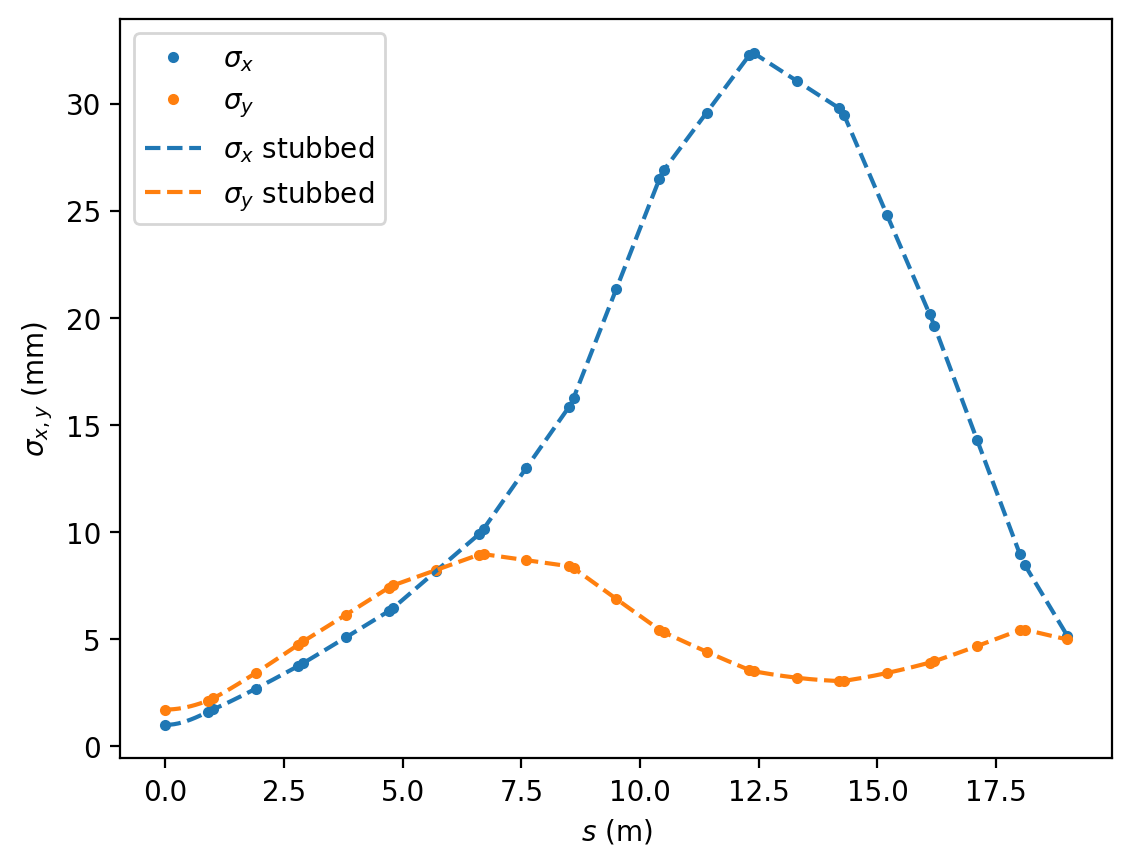

In [12]:
# plot beamsize vs s for optimal configuration
from bmadx import track_lattice_save_particles

all_p = track_lattice_save_particles(beam_in, lattice)
all_p_stubbed = track_lattice_save_particles(beam_in, lattice, 10)

stdx = np.array([torch.std(par.x).item() for par in all_p])
stdy = np.array([torch.std(par.y).item() for par in all_p])
stdx_stubbed = np.array([torch.std(par.x).item() for par in all_p_stubbed])
stdy_stubbed = np.array([torch.std(par.y).item() for par in all_p_stubbed])

s = np.array([par.s.item() for par in all_p])
s_stubbed = np.array([par.s.item() for par in all_p_stubbed])

plt.plot(s, stdx*1000, '.', color='C0', label=r'$\sigma_x$')
plt.plot(s, stdy*1000, '.', color='C1', label=r'$\sigma_y$')
plt.plot(s_stubbed, stdx_stubbed*1000, color='C0', linestyle='--', label=r'$\sigma_x$ stubbed')
plt.plot(s_stubbed, stdy_stubbed*1000, color='C1', linestyle='--',label=r'$\sigma_y$ stubbed')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()

Text(0, 0.5, '$y$ (mm)')

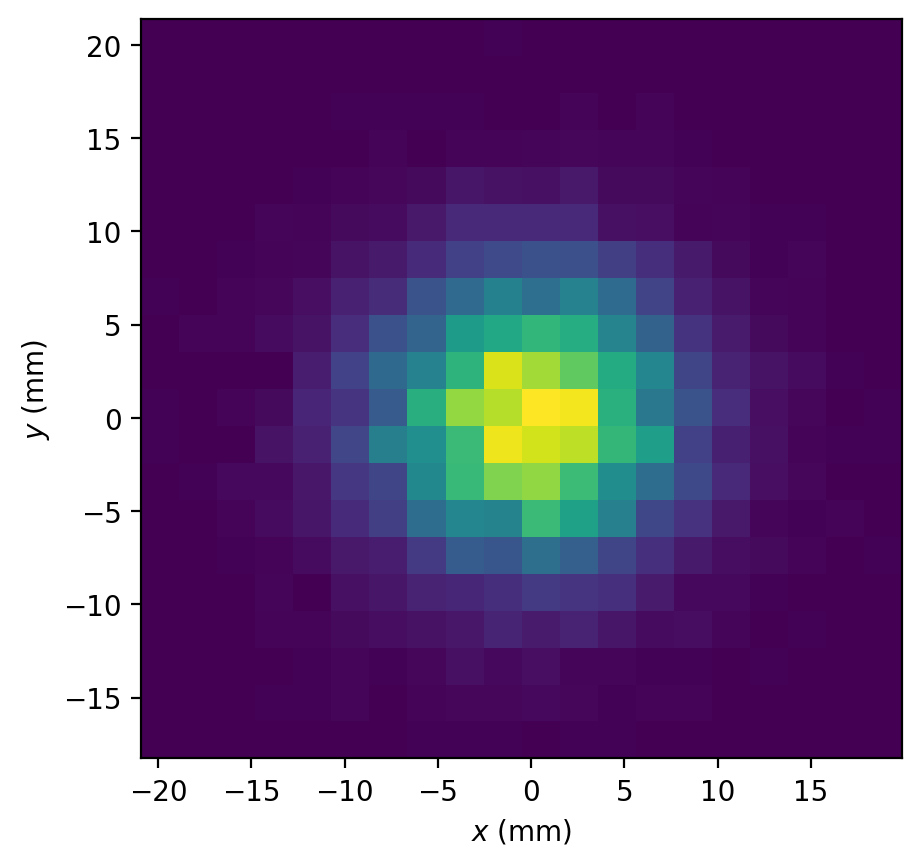

In [13]:
# plot final beam profile
fig, ax = plt.subplots()
ax.hist2d(all_p[-1].x.numpy()*1e3, all_p[-1].y.numpy()*1e3, bins=20)
ax.set_aspect('equal')
ax.set_xlabel(r'$x$ (mm)')
ax.set_ylabel(r'$y$ (mm)')

In [14]:
from torch.profiler import profile, record_function, ProfilerActivity

In [20]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model()
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2022-12-13 15:11:54 5607:296873 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2022-12-13 15:11:54 5607:296873 ActivityProfilerController.cpp:300] Completed Stage: Collection


-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
              model_inference        32.90%      13.533ms        99.91%      41.103ms      41.103ms             1  
                    aten::mul        11.46%       4.713ms        15.57%       6.406ms       7.040us           910  
                    aten::add        11.41%       4.693ms        13.51%       5.556ms       8.668us           641  
                   aten::sqrt         9.78%       4.025ms         9.78%       4.025ms      36.261us           111  
                     aten::to         1.75%     718.000us         6.99%       2.874ms       2.801us          1026  
               aten::_to_copy         3.85%       1.585ms         6.05% 

In [78]:
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    model().backward()

STAGE:2022-12-13 16:12:25 5607:296873 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2022-12-13 16:12:25 5607:296873 ActivityProfilerController.cpp:300] Completed Stage: Collection


In [79]:
print(prof.key_averages().table(sort_by='self_cpu_memory_usage'))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul        15.75%       8.396ms        21.13%      11.258ms       6.519us      57.34 Mb      44.82 Mb          1727  
                                              aten::add        12.71%       6.771ms        14.54%       7.749ms       7.627us      27.31 Mb      25.25 Mb          1016  
                                              aten::div         7.51%       4.003ms         7.87%       4.195ms       6.045us      20.37 Mb      20.26

In [80]:
print(prof.key_averages().table(sort_by='cpu_memory_usage'))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              aten::mul        15.75%       8.396ms        21.13%      11.258ms       6.519us      57.34 Mb      44.82 Mb          1727  
                                              aten::add        12.71%       6.771ms        14.54%       7.749ms       7.627us      27.31 Mb      25.25 Mb          1016  
                                              aten::div         7.51%       4.003ms         7.87%       4.195ms       6.045us      20.37 Mb      20.26

In [73]:
print(prof.key_averages().table())

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                 aten::unbind         0.30%      97.000us         0.45%     146.000us     146.000us           0 b           0 b             1  
                 aten::select         0.12%      38.000us         0.15%      49.000us       4.900us           0 b           0 b            10  
             aten::as_strided         0.04%      12.000us         0.04%      12.000us       0.857us           4 b           4 b            14  
                  aten::empty         0.20%      66.000us         0.20%      66.000us       0.717us         272 b         272 b         

In [59]:
prof.key_averages().total_average()

<FunctionEventAvg key=Total self_cpu_time=32.603ms cpu_time=4.123us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=20047456 cuda_memory_usage=0>

In [75]:
20047456 / (8e6)

2.505932

In [76]:
8232724 / (8e6)

1.0290905

In [62]:
print(profile.__doc__)

Profiler context manager.

    Args:
        activities (iterable): list of activity groups (CPU, CUDA) to use in profiling, supported values:
            ``torch.profiler.ProfilerActivity.CPU``, ``torch.profiler.ProfilerActivity.CUDA``.
            Default value: ProfilerActivity.CPU and (when available) ProfilerActivity.CUDA.
        schedule (Callable): callable that takes step (int) as a single parameter and returns
            ``ProfilerAction`` value that specifies the profiler action to perform at each step.
        on_trace_ready (Callable): callable that is called at each step when ``schedule``
            returns ``ProfilerAction.RECORD_AND_SAVE`` during the profiling.
        record_shapes (bool): save information about operator's input shapes.
        profile_memory (bool): track tensor memory allocation/deallocation.
        with_stack (bool): record source information (file and line number) for the ops.
        with_flops (bool): use formula to estimate the FLOPs (floatin

In [71]:
prof.key_averages()

[<FunctionEventAvg key=aten::unbind self_cpu_time=97.000us cpu_time=146.000us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::select self_cpu_time=38.000us cpu_time=4.900us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=0 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::as_strided self_cpu_time=12.000us cpu_time=0.857us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=4 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::empty self_cpu_time=66.000us cpu_time=0.717us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=272 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::to self_cpu_time=722.000us cpu_time=3.247us  self_cuda_time=0.000us cuda_time=0.000us input_shapes= cpu_memory_usage=8232724 cuda_memory_usage=0>,
 <FunctionEventAvg key=aten::lift_fresh self_cpu_time=0.000us cpu_time=0.000us  self_cuda_time=0.000us cuda_time=0.000us inpu

In [ ]:
a.element_size() * a.nelement()